# School Greening Pilot: Single School Workflow
This lab notebook walks through the end-to-end flow for one Phoenix school so we can validate the data pipeline before scaling it out. We'll load the GeoJSON of school footprints, pick a single campus, grab reference imagery and temperature layers from the Microsoft Planetary Computer, and compute basic metrics such as NDVI and average land surface temperature.

In [ ]:
# Install session dependencies if needed (uncomment when running locally)
%pip install --quiet planetary-computer pystac-client stackstac rioxarray geopandas shapely rasterio folium tqdm

In [35]:
from pathlib import Path
import json
from datetime import datetime
from typing import Tuple
import requests
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import planetary_computer as pc
import rasterio
import rioxarray
import xarray as xr
from matplotlib.colors import ListedColormap
from pyproj import Transformer
from pystac_client import Client
from shapely.geometry import shape, mapping
from shapely.ops import transform
from rasterio.mask import mask

## Workflow checkpoints
1. Load and explore the GeoJSON of Phoenix schools.
2. Pick a single pilot school and derive its spatial footprint + centroid.
3. Retrieve supporting imagery (NAIP) and temperature data (Landsat Collection 2 Level 2) from the Microsoft Planetary Computer.
4. Clip the assets to the campus footprint and compute quick-look metrics: NDVI and average land surface temperature.
5. Visualize the results for validation before scaling out.

In [3]:
# Load the school footprints (expects phoenix_schools.geojson alongside this notebook)
notebook_dir = Path(__file__).parent if '__file__' in globals() else Path().resolve()
schools_path = next((p for p in [notebook_dir / 'phoenix_schools.geojson', notebook_dir / 'lab' / 'phoenix_schools.geojson'] if p.exists()), None)
if schools_path is None:
    raise FileNotFoundError("Place phoenix_schools.geojson in this folder (or lab/) before running the lab.")
schools_gdf = gpd.read_file(schools_path, engine='pyogrio', on_invalid='fix').to_crs('EPSG:4326')
print(f"Total school features: {len(schools_gdf):,}")
schools_gdf[['name', 'amenity']].head()

Total school features: 1,056


/home/prasadkomma/ignite25-LAB597-make-more-informed-decisions-with-geospatial-intelligence/.venv/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: Non closed ring detected. To avoid accepting it, set the OGR_GEOMETRY_ACCEPT_UNCLOSED_RING configuration option to NO
  return ogr_read(


,name,amenity
0,Grand Canyon University,university
1,None,university
2,Biltmore Preparatory Academy,school
3,Roosevelt School,school
4,Madison School Number Two,school


In [4]:
# Pick the pilot school record (handle duplicates by taking the largest footprint)
pilot_school_name = 'Biltmore Preparatory Academy'
pilot_candidates = schools_gdf[schools_gdf['name'] == pilot_school_name].copy()
if pilot_candidates.empty:
    raise ValueError(f"Couldn't find {pilot_school_name} in the GeoJSON.")
pilot_candidates['area_m2'] = pilot_candidates.geometry.to_crs('EPSG:3857').area
pilot_row = pilot_candidates.sort_values('area_m2', ascending=False).iloc[0]

# Extract geometry, bounds, and a centroid calculated in a projected CRS for accuracy
pilot_shape = pilot_row.geometry
pilot_bounds = pilot_shape.bounds
centroid_projected = gpd.GeoSeries([pilot_shape], crs='EPSG:4326').to_crs('EPSG:3857').centroid
pilot_centroid = centroid_projected.to_crs('EPSG:4326').iloc[0]

print(pilot_row[['name', 'addr:street', 'addr:postcode']])
print(f"Bounds (xmin, ymin, xmax, ymax): {pilot_bounds}")
print(f"Centroid (lon, lat): ({pilot_centroid.x:.6f}, {pilot_centroid.y:.6f})")

name             Biltmore Preparatory Academy
addr:street                 North 34th Street
addr:postcode                           85018
Name: 2, dtype: object
Bounds (xmin, ymin, xmax, ymax): (-112.0108026, 33.5041132, -112.0085911, 33.5062396)
Centroid (lon, lat): (-112.009678, 33.505304)


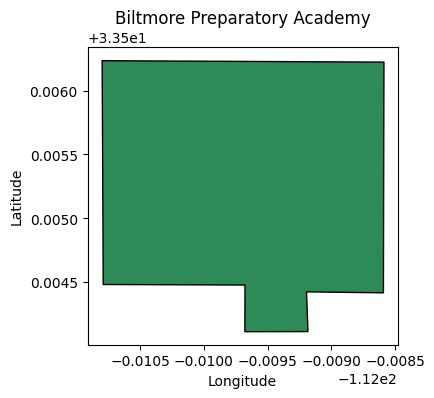

In [18]:
# Quick visualization of the pilot school footprint
ax = gpd.GeoSeries([pilot_shape]).plot(figsize=(4, 4), color='seagreen', edgecolor='black')
ax.set_title(pilot_school_name)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [5]:
# Helper functions for bounding boxes and STAC search
def expand_bounds(bounds: Tuple[float, float, float, float], buffer_degrees: float = 0.0008) -> Tuple[float, float, float, float]:
    xmin, ymin, xmax, ymax = bounds
    return (xmin - buffer_degrees, ymin - buffer_degrees, xmax + buffer_degrees, ymax + buffer_degrees)

def search_planetary_computer(collection: str, bbox: Tuple[float, float, float, float], start: str, end: str, **search_kwargs):
    """Return the most recent STAC item intersecting the bbox and date range."""
    catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1', modifier=pc.sign_inplace)
    search_parameters = {
        'collections': [collection],
        'bbox': bbox,
        'datetime': f"{start}/{end}",
        'max_items': search_kwargs.pop('max_items', 20),
        'limit': search_kwargs.pop('limit', 20),
        'sortby': search_kwargs.pop('sortby', [{'field': 'properties.datetime', 'direction': 'desc'}]),
    }
    search_parameters.update(search_kwargs)
    results = catalog.search(**search_parameters).item_collection()
    if not results:
        raise ValueError(f'No items found for collection={collection} in the requested window.')
    return results[0]

In [14]:
# Locate NAIP and Landsat scenes covering the campus
temporal_start = '2023-01-01'
temporal_end = '2024-12-31'
expanded_bounds = expand_bounds(pilot_bounds)
naip_item = search_planetary_computer('naip', expanded_bounds, temporal_start, temporal_end)
landsat_item = search_planetary_computer(
    'landsat-c2-l2',
    expanded_bounds,
    temporal_start,
    temporal_end,
    query={'eo:cloud_cover': {'lt': 20}}
)
print(f"NAIP item: {naip_item.id}")
print(f"Landsat item: {landsat_item.id}")

NAIP item: az_m_3311232_se_12_030_20230917_20240304
Landsat item: LC08_L2SP_037037_20241209_02_T1


In [15]:
# Inspect asset keys for diagnostics
print('NAIP assets:', list(naip_item.assets.keys()))
print('Landsat assets:', list(landsat_item.assets.keys()))

NAIP assets: ['image', 'thumbnail', 'tilejson', 'rendered_preview']
Landsat assets: ['qa', 'ang', 'red', 'blue', 'drad', 'emis', 'emsd', 'trad', 'urad', 'atran', 'cdist', 'green', 'nir08', 'lwir11', 'swir16', 'swir22', 'coastal', 'mtl.txt', 'mtl.xml', 'mtl.json', 'qa_pixel', 'qa_radsat', 'qa_aerosol', 'tilejson', 'rendered_preview']


In [17]:
# Use COG-friendly windowed read + mask so we download only pixels intersecting the campus
naip_asset = naip_item.assets['image']
naip_href_signed = pc.sign(naip_asset.href)
with rasterio.open(naip_href_signed) as src:
    reproj = Transformer.from_crs('EPSG:4326', src.crs, always_xy=True).transform
    pilot_shape_src = transform(reproj, pilot_shape)
    clipped_data, clipped_transform = mask(src, [mapping(pilot_shape_src)], crop=True)
    clipped_data = clipped_data.astype('float32')
    if src.nodata is not None:
        clipped_data = np.where(clipped_data == src.nodata, np.nan, clipped_data)
    naip_clip = xr.DataArray(
        clipped_data,
        dims=("band", "y", "x"),
        coords={"band": list(src.indexes)},
        name="naip_rgb",
    ).rio.write_transform(clipped_transform).rio.write_crs(src.crs)

print(naip_clip)

<xarray.DataArray 'naip_rgb' (band: 4, y: 791, x: 689)> Size: 9MB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0

### See the campus from above
Here's the true-color NAIP scene so students can orient themselves with a familiar aerial view before diving into the analytics.

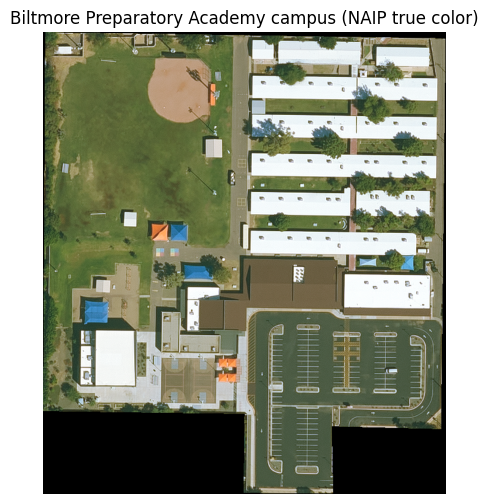

In [19]:
# Display a contrast-stretched RGB image so students can recognize the campus
rgb = np.stack([naip_clip.sel(band=i).values for i in (1, 2, 3)], axis=-1)
if np.isfinite(rgb).any():
    low, high = np.nanpercentile(rgb[np.isfinite(rgb)], (2, 98))
    scale = max(high - low, 1)
    rgb_normalized = np.clip((rgb - low) / scale, 0, 1)
else:
    rgb_normalized = np.zeros_like(rgb, dtype="float32")

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(rgb_normalized)
ax.set_title(f"{pilot_school_name} campus (NAIP true color)")
ax.axis("off")
plt.show()

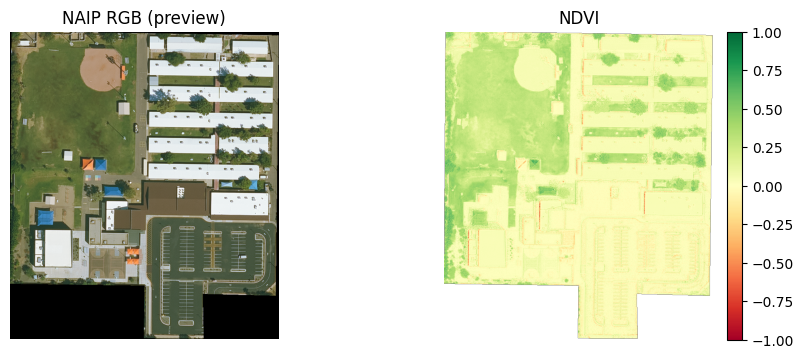

Mean NDVI over campus: 0.114


In [20]:
# Compute NDVI from NAIP (band order: R, G, B, NIR)
red = naip_clip.sel(band=1).astype('float32')
nir = naip_clip.sel(band=4).astype('float32')
ndvi = (nir - red) / (nir + red)
ndvi = ndvi.where(np.isfinite(ndvi))
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
naip_rgb = np.stack([naip_clip.sel(band=i).values for i in (1, 2, 3)])
naip_rgb_plot = np.transpose(naip_rgb, (1, 2, 0))
axes[0].imshow(np.clip(naip_rgb_plot / np.nanmax(naip_rgb_plot), 0, 1))
axes[0].set_title('NAIP RGB (preview)')
axes[0].axis('off')
ndvi_im = axes[1].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1].set_title('NDVI')
axes[1].axis('off')
fig.colorbar(ndvi_im, ax=axes[1], fraction=0.046, pad=0.04)
plt.show()
print(f"Mean NDVI over campus: {ndvi.mean().item():.3f}")

In [41]:
# Download and clip Landsat Collection 2 Level 2 thermal assets and compute surface temperature
thermal_keys = ['trad', 'urad', 'drad', 'emis', 'atran']
clip_geoms = [pilot_shape]
clip_crs = 'EPSG:4326'

# Helper to open, clip, and scale thermal rasters so they share a grid
clipped_assets = {}
for key in thermal_keys:
    asset = landsat_item.assets[key]
    href = pc.sign(asset.href)
    arr = rioxarray.open_rasterio(href, masked=True, cache=True).astype('float32')
    arr = arr.rio.clip(clip_geoms, clip_crs, drop=True)
    band_meta = asset.extra_fields.get('raster:bands', [{}])[0]
    scale = band_meta.get('scale', 1.0)
    offset = band_meta.get('offset', 0.0)
    scaled = (arr * scale + offset).squeeze()
    clipped_assets[key] = scaled

rad = clipped_assets['trad']
up = clipped_assets['urad']
down = clipped_assets['drad']
emissivity = clipped_assets['emis'].clip(0.0001, 0.9999)
transmittance = clipped_assets['atran'].clip(0.0001)

# Radiative transfer equation to estimate surface-leaving radiance
radiance_surface = (rad - up - (1 - emissivity) * down) / (emissivity * transmittance)
radiance_surface = xr.where(radiance_surface <= 0, np.nan, radiance_surface)

# Fetch thermal constants (K1, K2) from the product metadata
mtl_href = pc.sign(landsat_item.assets['mtl.json'].href)
mtl_response = requests.get(mtl_href, timeout=30)
mtl_response.raise_for_status()
mtl = mtl_response.json()
thermal_constants = mtl['LANDSAT_METADATA_FILE']['LEVEL1_THERMAL_CONSTANTS']
k1 = float(thermal_constants['K1_CONSTANT_BAND_10'])
k2 = float(thermal_constants['K2_CONSTANT_BAND_10'])

lst_kelvin = k2 / np.log((k1 / radiance_surface) + 1)
lst_celsius = lst_kelvin - 273.15
lst_celsius = lst_celsius.where(np.isfinite(lst_celsius))

print(f"Mean temperature (°C): {float(lst_celsius.mean().item()):.2f}")

ERROR 1: PROJ: internal_proj_create_from_database: /home/prasadkomma/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/prasadkomma/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/prasadkomma/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/prasadkomma/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_create_from_database: /home/prasadkomma/anaconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.M

Mean temperature (°C): 22.67


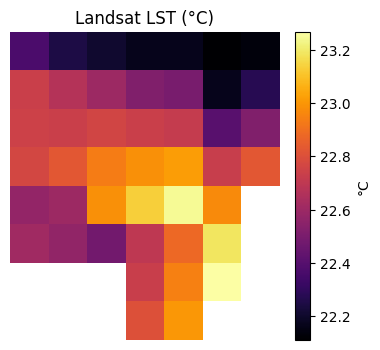

In [42]:
# Visualize temperature distribution
plt.figure(figsize=(5, 4))
temp_plot = plt.imshow(lst_celsius.squeeze(), cmap='inferno')
plt.title('Landsat LST (°C)')
plt.axis('off')
plt.colorbar(temp_plot, fraction=0.046, pad=0.04, label='°C')
plt.show()

## Next steps
- Validate the NAIP + Landsat selections across different years to build a time series.
- Compare campus-level NDVI and LST against city-wide percentiles to rank schools.
- Persist clipped rasters or summary stats so the workshop can scale to dozens of campuses without re-querying raw imagery.